In [15]:
# script to make selection plots in AN/presentations for bkg distribution checks


import ROOT as rt
import csv
import re
import sys
import collections
import os
from collections import OrderedDict
import uproot
import pandas as pd
from root_numpy import array2tree


import scipy
import awkward
import numpy as np
import time
import numba
from numba import jit
from matplotlib import pyplot as plt
sys.path.append('/storage/af/user/christiw/gpu/christiw/llp/delayed_jet_analyzer/lib/')
from histo_utilities import create_TH1D, create_TH2D, std_color_list, create_TGraph, make_ratio_plot
from helper_functions import deltaR, deltaPhi
import numpy as np
from scipy.stats import norm
import math
import CMS_lumi, tdrstyle
a= tdrstyle.setTDRStyle()
CMS_lumi.writeExtraText = 0

wH = 1
Z_MASS = 91.2



# donotdelete = []
print(sys.version)

3.6.8 (default, Aug  7 2019, 17:28:10) 
[GCC 4.8.5 20150623 (Red Hat 4.8.5-39)]


# Load ntuples

In [16]:
fpath =OrderedDict()
tree = OrderedDict()


start_t = time.time()
data_year = 'full'

v1 = 'V1p17'


v2 = '/v5/v163/'


data_path = '/storage/af/group/phys_exotica/delayedjets/displacedJetMuonAnalyzer/csc/'+v1+'/Data2018/'+v2+'/normalized/'




if data_year == 2016:
    fpath['data'] = data_path + 'Run2_displacedJetMuonNtupler_'+v1+'_Data2016_Run2016-HighMET-07Aug17_goodLumi.root'
elif data_year == 2017:
    fpath['data'] = data_path + 'Run2_displacedJetMuonNtupler_'+v1+'_Data2017_Run2017-HighMET-17Nov2017_goodLumi.root'
elif data_year == 2018:
    fpath['data'] = data_path + 'Run2_displacedJetMuonNtupler_'+v1+'_Data2018_17Sept2018_Run2018-HighMET-17Sep2018_goodLumi.root'
else: #2016, 2017, 2018AB
    fpath['data'] = data_path + 'Run2_displacedJetMuonNtupler_'+v1+'_Data2016_Data2017_Data2018-HighMET_goodLumi.root'

decay = 'dddd'
mass = [  '7', '15', '40','55']
# ctaus  = ['100','1000','10000','100000']
ctaus  = ['1000']
for ct in ctaus:
    for m in mass:
        v2 = '/v1/v163'
        mc_path = '/storage/af/group/phys_exotica/delayedjets/displacedJetMuonAnalyzer/csc/'+v1+'/MC_all'+v2+'/normalized/'
        fpath[decay+'_m'+m+'ctau'+ct] = mc_path + 'ggH_HToSSTo'+decay+'_MH-125_MS-'+str(m)+'_ctau-'+ct+'_137000pb_weighted.root'

# v2 = '/v2/v163'
# mc_path = '/storage/af/group/phys_exotica/delayedjets/displacedJetMuonAnalyzer/csc/'+v1+'/MC_Fall18'+v2+'/normalized/'
# decay = 'PiPlusPiMinus'
# m_ct = ['ms0p4_pl10',  'ms0p4_pl50',  'ms1p0_pl125', 'ms1p0_pl25',  'ms2p0_pl250', 'ms2p0_pl50', 'ms4p0_pl100', 'ms4p0_pl500', ]


NEvents = {}
for k,v in fpath.items():
    print (k, v)
    root_dir = uproot.open(v) 

    tree[k] = root_dir['MuonSystem']
    NEvents[k] = root_dir['NEvents'][1]
    a = tree[k]["weight"].array()
    print("NEvents",NEvents[k])
    # 22743688.0


data /storage/af/group/phys_exotica/delayedjets/displacedJetMuonAnalyzer/csc/V1p17/Data2018//v5/v163//normalized/Run2_displacedJetMuonNtupler_V1p17_Data2016_Data2017_Data2018-HighMET_goodLumi.root
NEvents 22763250.0
dddd_m7ctau1000 /storage/af/group/phys_exotica/delayedjets/displacedJetMuonAnalyzer/csc/V1p17/MC_all/v1/v163/normalized/ggH_HToSSTodddd_MH-125_MS-7_ctau-1000_137000pb_weighted.root
NEvents 106227390.0
dddd_m15ctau1000 /storage/af/group/phys_exotica/delayedjets/displacedJetMuonAnalyzer/csc/V1p17/MC_all/v1/v163/normalized/ggH_HToSSTodddd_MH-125_MS-15_ctau-1000_137000pb_weighted.root
NEvents 102585040.0
dddd_m40ctau1000 /storage/af/group/phys_exotica/delayedjets/displacedJetMuonAnalyzer/csc/V1p17/MC_all/v1/v163/normalized/ggH_HToSSTodddd_MH-125_MS-40_ctau-1000_137000pb_weighted.root
NEvents 106752310.0
dddd_m55ctau1000 /storage/af/group/phys_exotica/delayedjets/displacedJetMuonAnalyzer/csc/V1p17/MC_all/v1/v163/normalized/ggH_HToSSTodddd_MH-125_MS-55_ctau-1000_137000pb_weighted

# load variables

In [62]:

JET_PT_CUT = 10.0
MUON_PT_CUT = 20.0
N_RECHIT_CUT = 90
jetPt_cut = 50
tightid = False
ring_cut = 50

cut_based = True
cut_based_version = 'v4'

intime = True
DPHI_CUT = 1


sel_ev = {}
cluster_index = ''

cscClusterSize = {}
cscRechitClusterEta = {}
cscRechitClusterPhi = {}
dtRechitClusterAvgStation = {}
cscRechitClusterAvgStation = {}
dtRechitClusterDphi = {}

dtRechitClusterAvgStation = {}

cscRechitClusterTimeWeighted = {}
dtRechitCluster_match_RPCBx_dPhi0p5 = {}
deltaEta = {}
category = 1
#2csc, 2dt, 1csc+1dt
for k, T in tree.items():
    if not k == 'data':continue

########### SELECTION: CLUSTERS ############
   
    sel_csccluster = T.array('cscRechitCluster' + cluster_index + 'TimeSpreadWeightedAll')<20
#     sel_csccluster = np.logical_and(sel_csccluster, np.abs(T.array('cscRechitCluster' + cluster_index + 'MetEENoise_dPhi'))<1.2)
    sel_csccluster = np.logical_and(sel_csccluster, T.array('cscRechitCluster' + cluster_index + 'JetVetoPt')<30)
    sel_csccluster = np.logical_and(sel_csccluster, T.array('cscRechitCluster' + cluster_index + 'Me11Ratio')<1)
    sel_csccluster = np.logical_and(sel_csccluster, np.logical_not(np.logical_and(T.array('cscRechitClusterMuonVetoPt') >= 30, T.array('cscRechitClusterMuonVetoGlobal'))))

#     sel_csccluster = np.logical_and(sel_csccluster, np.logical_and(T.array('cscRechitCluster' + cluster_index + 'TimeWeighted')< 12.5, \
#                                                                          T.array('cscRechitCluster' + cluster_index + 'TimeWeighted') > -5))
   
        
    sel_dtcluster = np.abs(T.array('dtRechitClusterMetEENoise_dPhi')) < 100000
    sel_dtcluster = np.logical_and(sel_dtcluster, np.logical_not(np.logical_and(T.array('dtRechitClusterMuonVetoPt') >= 10, T.array('dtRechitClusterMuonVetoLooseId'))))
    sel_dtcluster = np.logical_and(sel_dtcluster, np.abs(T.array('dtRechitClusterJetVetoPt')) < 50)
    sel_dtcluster = np.logical_and(sel_dtcluster, np.logical_not(np.logical_and(T.array('dtRechitClusterMaxStation')==1, T.array('dtRechitClusterMaxStationRatio')>0.9)))
    
    
    cut = 5
    station = (T.array('dtRechitClusterNSegmentStation1')>cut).astype(int)+(T.array('dtRechitClusterNSegmentStation2')>cut).astype(int)\
+(T.array('dtRechitClusterNSegmentStation3')>cut).astype(int)+(T.array('dtRechitClusterNSegmentStation4')>cut).astype(int)

    max_station = np.maximum(np.maximum(np.maximum(T.array('dtRechitClusterNSegmentStation1'), T.array('dtRechitClusterNSegmentStation2')), T.array('dtRechitClusterNSegmentStation3')), T.array('dtRechitClusterNSegmentStation4'))
    min_station = np.minimum(np.minimum(np.minimum(T.array('dtRechitClusterNSegmentStation1'), T.array('dtRechitClusterNSegmentStation2')), T.array('dtRechitClusterNSegmentStation3')), T.array('dtRechitClusterNSegmentStation4'))

    sel_dtcluster = np.logical_and(sel_dtcluster, np.logical_or(station<4, min_station/max_station<0.4)) #remove if both clusters are 4 stations
      
########### SELECTION: JETS ############
    
    sel_jet = np.logical_and(T.array('jetPt') > 30, np.abs(T.array('jetEta')) < 2.4 )
    sel_jet = np.logical_and(T.array('jetTightPassId'), sel_jet)



########### SELECTION: EVENTS ############
    hlt = T['HLTDecision'].array()
    sel_ev[k] = T.array('METNoMuTrigger')
    sel_ev[k] = np.logical_and(sel_ev[k], (T.array('nDtRings')+T.array('nCscRings'))<10)
    sel_ev[k] = np.logical_and(sel_ev[k] ,T.array('metEENoise') > 200)
    sel_ev[k] = np.logical_and(sel_ev[k] , sel_jet.sum()>=1)
    sel_ev[k] = np.logical_and(sel_ev[k],T.array('Flag2_all'))
    
    nCscClusters[k] = sel_csccluster.sum()[sel_ev[k]]
    if category == 0:
        sel_ev[k]  = np.logical_and(sel_ev[k],sel_csccluster.sum() >= 2)
#         sel_ev[k]  = np.logical_and(sel_ev[k],sel_dtcluster.sum() == 0)
    elif category == 1:
        sel_ev[k]  = np.logical_and(sel_ev[k],sel_dtcluster.sum() >= 2)
#         sel_ev[k]  = np.logical_and(sel_ev[k],sel_csccluster.sum() == 0)
    else:
        sel_ev[k]  = np.logical_and(sel_ev[k],sel_csccluster.sum() == 1)
        sel_ev[k]  = np.logical_and(sel_ev[k],sel_dtcluster.sum() == 1)    
########### BRANCHES ############

   ##### event variables ##### 
    
    gLLP_beta[k] = T.array('gLLP_beta')[sel_ev[k]]
   
    
   
    if category == 0:

        
        cscClusterSize[k] =  T.array('cscRechitCluster' + cluster_index + 'Size')[sel_csccluster][sel_ev[k]][:,:]
        cscRechitClusterTimeWeighted[k] =  T.array('cscRechitCluster' + cluster_index + 'TimeWeighted')[sel_csccluster][sel_ev[k]][:,:]
        cscRechitClusterPhi[k] =  T.array('cscRechitCluster' + cluster_index + 'Phi')[sel_csccluster][sel_ev[k]]  
        cscRechitClusterAvgStation[k] =  T.array('cscRechitCluster' + cluster_index + 'AvgStation10')[sel_csccluster][sel_ev[k]]  
        cscRechitClusterEta[k] =  T.array('cscRechitCluster' + cluster_index + 'Eta')[sel_csccluster][sel_ev[k]]  
        
    elif category == 1:
        dtRechitCluster_match_RPCBx_dPhi0p5[k] = T.array('dtRechitCluster_match_RPCBx_dPhi0p5')[sel_dtcluster][sel_ev[k]][:,:]
        dtRechitCluster_match_RPChits_dPhi0p5[k] = T.array('dtRechitCluster_match_RPChits_dPhi0p5')[sel_dtcluster][sel_ev[k]][:,:]
        dtRechitClusterSize[k] =  T.array('dtRechitClusterSize')[sel_dtcluster][sel_ev[k]][:,:]
        dtRechitClusterEta[k] =  T.array('dtRechitClusterEta')[sel_dtcluster][sel_ev[k]][:,:]
        dtRechitClusterPhi[k] =  T.array('dtRechitClusterPhi')[sel_dtcluster][sel_ev[k]][:,:]
        dtRechitClusterAvgStation[k] =  T.array('dtRechitClusterAvgStation10')[sel_dtcluster][sel_ev[k]][:,:]
    else:
     
        dtRechitCluster_match_RPCBx_dPhi0p5[k] = T.array('dtRechitCluster_match_RPCBx_dPhi0p5')[sel_dtcluster][sel_ev[k]][:,0]

        dtRechitClusterPhi[k] = T.array('dtRechitClusterPhi')[sel_dtcluster][sel_ev[k]][:,0]
        dtRechitClusterEta[k] = T.array('dtRechitClusterEta')[sel_dtcluster][sel_ev[k]][:,0]
        dtRechitClusterAvgStation[k] = T.array('dtRechitClusterAvgStation10')[sel_dtcluster][sel_ev[k]][:,0]
        dtRechitClusterSize[k] =  T.array('dtRechitClusterSize')[sel_dtcluster][sel_ev[k]][:,0]
#         dtRechitClusterNStation[k] =  T.array('dtRechitClusterNStation10')[sel_dtcluster][sel_ev[k]][:,0]

        cscRechitClusterAvgStation[k] = T.array('cscRechitCluster' + cluster_index + 'AvgStation10')[sel_csccluster][sel_ev[k]][:,0]

        cscRechitClusterTimeWeighted[k] =  T.array('cscRechitCluster' + cluster_index + 'TimeWeighted')[sel_csccluster][sel_ev[k]][:,0]
        
        cscRechitClusterPhi[k] = T.array('cscRechitCluster' + cluster_index + 'Phi')[sel_csccluster][sel_ev[k]][:,0]
        cscRechitClusterEta[k] = T.array('cscRechitCluster' + cluster_index + 'Eta')[sel_csccluster][sel_ev[k]][:,0]
        cscClusterSize[k] =  T.array('cscRechitCluster' + cluster_index + 'Size')[sel_csccluster][sel_ev[k]][:,0]
        cscRechitClusterTime[k] =  T.array('cscRechitCluster' + cluster_index + 'TimeTotal')[sel_csccluster][sel_ev[k]][:,0]


        


# CSC Cluster Plots

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Info in <TCanvas::Print>: png file /storage/af/user/christiw/gpu/christiw/llp/delayed_jet_analyzer/plots/MuonSystem_Analysis/double_tag/selection_plots_final//v1/v163/csccsc_cscRechitClusterTimeWeighted.png has been created
Info in <TCanvas::Print>: pdf file /storage/af/user/christiw/gpu/christiw/llp/delayed_jet_analyzer/plots/MuonSystem_Analysis/double_tag/selection_plots_final//v1/v163/csccsc_cscRechitClusterTimeWeighted.pdf has been created
Info in <TCanvas::SaveSource>: C++ Macro file: /storage/af/user/christiw/gpu/christiw/llp/delayed_jet_analyzer/plots/MuonSystem_Analysis/double_tag/selection_plots_final//v1/v163/csccsc_cscRechitClusterTimeWeighted.C has been generated
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Info in <TCanvas::Print>: png file /storage/af/user/christiw/gpu/christiw/llp/delayed_jet_analyzer/plots/MuonSystem_Analysis/double_tag/selection_plots_final//v1/v163/csccsc_cscR

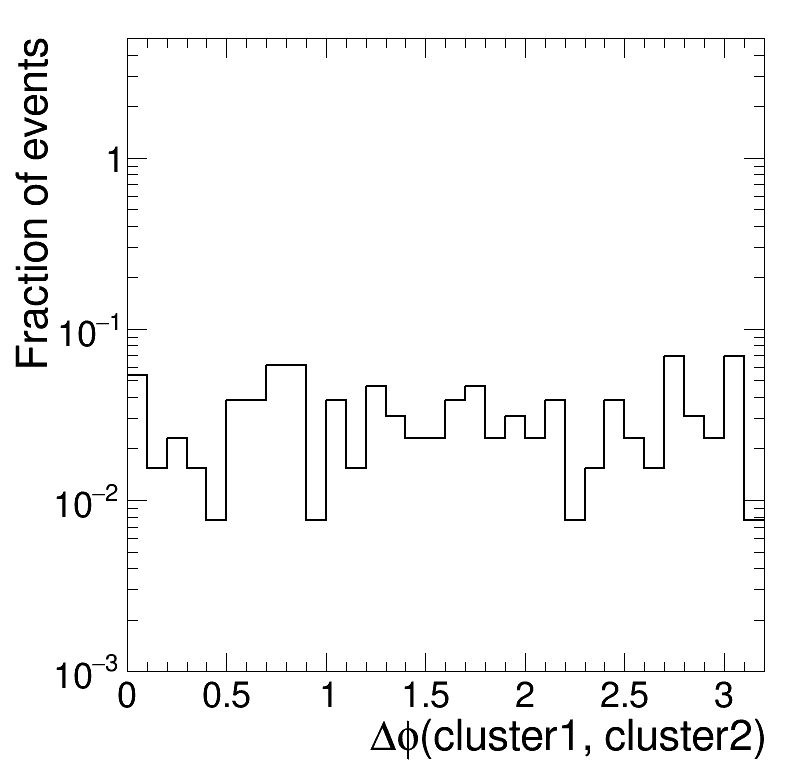

In [61]:
assert(category == 0)




var = [cscRechitClusterTimeWeighted, cscRechitClusterEta, cscRechitClusterPhi]
name = ['cscRechitClusterTimeWeighted', 'cscRechitClusterEta', 'clusterDPhi']

xaxis = ['cluster time [ns]', 'cluster #eta', '#Delta#phi(cluster1, cluster2)']

# bins = [ [100,-100,120], [50,0,100], [50,0,500],[50,0,200], [32,0,3.2], [25,0,1.1],[25,0.8,2.5],[30,0,3.2],[35,1,4], [40,0,3.2], [40,0,8], [40,0,5]]

bins = [ [100,-100,120], [25,0.8,2.5], [32,0,3.2]]

setlogy = [1,1, 1]

for index in range(len(var)):
#     if not index == 2:continue
    c = rt.TCanvas('c','c', 800, 800)
    leg = rt.TLegend(0.6,0.7,0.80,0.92)


    leg.SetTextSize(0.03)
    leg.SetBorderSize(0)
    leg.SetEntrySeparation(0.01)
    h = {}

    for i, k in enumerate(weight.keys()):
        sel_csccluster =  cscClusterSize[k]<1000000
        if index > 0: 
            sel_csccluster =  np.logical_and(sel_csccluster, cscRechitClusterTimeWeighted[k]<12.5)
            sel_csccluster =  np.logical_and(sel_csccluster, cscRechitClusterTimeWeighted[k]>-5)
        cond = sel_csccluster.sum()==2
        if k == 'data':
            cond= np.logical_and(cond, cscClusterSize[k].min()<100)
        if category == 0:
            if index <= 1:h[k] = create_TH1D(np.hstack((var[index][k][sel_csccluster][cond][:,0], var[index][k][sel_csccluster][cond][:,1])), axis_title = [xaxis[index], 'Fraction of events'], binning = bins[index])
            else: h[k] = create_TH1D(np.abs(deltaPhi(var[index][k][sel_csccluster][cond][:,0], var[index][k][sel_csccluster][cond][:,1])), axis_title = [xaxis[index], 'Fraction of events'], binning = bins[index])
                #             else: h[k] = create_TH1D(var[index][k][sel_csccluster][cond].max(), axis_title = [xaxis[index], 'Fraction of events'], binning = bins[index])
        
            if k == 'data':leg.AddEntry(h[k],k+'(N_{rechits}<100)')
            elif 'Pi' in k:leg.AddEntry(h[k],k)
            else: leg.AddEntry(h[k],'m_{S} = ' + k[k.find('m')+1:k.find('ctau')] + ' GeV, c#tau = 1 m')

            h[k].SetLineColor(std_color_list[i])
            if h[k].Integral()>0:h[k].Scale(1./h[k].Integral())
            h[k].SetMaximum(5)
            h[k].SetMinimum(1e-3)
          
            h[k].Draw('hist same')
               
#     leg.Draw()
    c.SetRightMargin(0.04)


    if setlogy[index]: c.SetLogy()
    c.Draw()
    plot_path = '/storage/af/user/christiw/gpu/christiw/llp/delayed_jet_analyzer/plots/MuonSystem_Analysis/double_tag/selection_plots_final/'
    c.SaveAs(plot_path+v2+'/csccsc_'+name[index]+".png")
    c.SaveAs(plot_path+v2+'/csccsc_'+name[index]+".pdf")
    c.SaveAs(plot_path+v2+'/csccsc_'+name[index]+".C")




# DT Cluster Plots

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Info in <TCanvas::Print>: png file /storage/af/user/christiw/gpu/christiw/llp/delayed_jet_analyzer/plots/MuonSystem_Analysis/double_tag/selection_plots_final//v1/v163/dtdt_dtRechitCluster_match_RPCBx_dPhi0p5.png has been created
Info in <TCanvas::Print>: pdf file /storage/af/user/christiw/gpu/christiw/llp/delayed_jet_analyzer/plots/MuonSystem_Analysis/double_tag/selection_plots_final//v1/v163/dtdt_dtRechitCluster_match_RPCBx_dPhi0p5.pdf has been created
Info in <TCanvas::SaveSource>: C++ Macro file: /storage/af/user/christiw/gpu/christiw/llp/delayed_jet_analyzer/plots/MuonSystem_Analysis/double_tag/selection_plots_final//v1/v163/dtdt_dtRechitCluster_match_RPCBx_dPhi0p5.C has been generated
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Info in <TCanvas::Print>: png file /storage/af/user/christiw/gpu/christiw/llp/delayed_jet_analyzer/plots/MuonSystem_Analysis/double_tag/selection_plots_final//v1/v

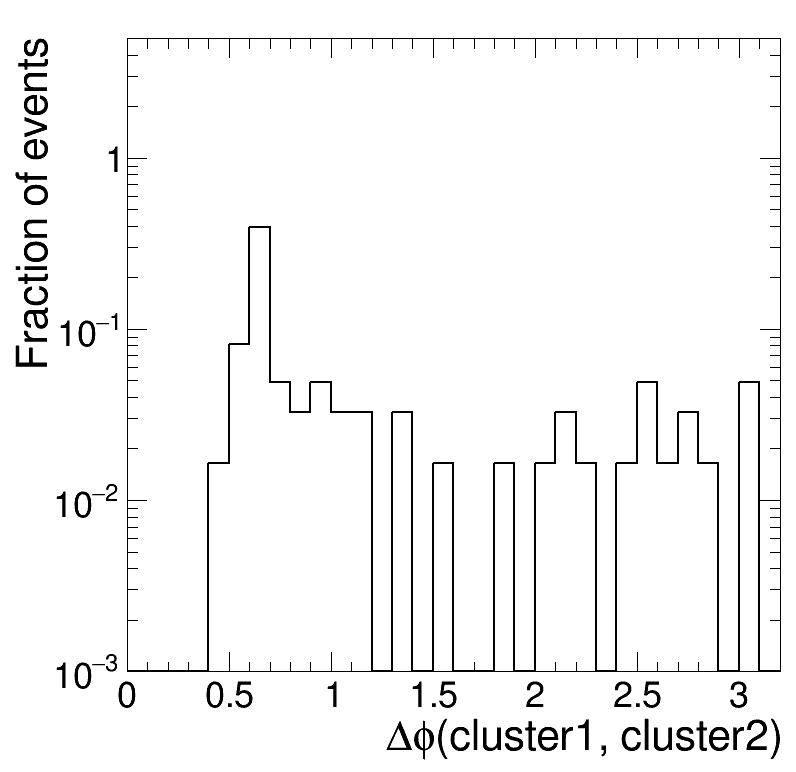

In [63]:
assert(category == 1)

var = [dtRechitCluster_match_RPCBx_dPhi0p5, dtRechitClusterEta, dtRechitClusterAvgStation, dtRechitClusterPhi]
name = ['dtRechitCluster_match_RPCBx_dPhi0p5', 'dtRechitClusterEta', 'dtRechitClusterAvgStation', 'clusterDPhi']
xaxis = ['dt cluster BX', 'cluster #eta', 'cluster average station', '#Delta#phi(cluster1, cluster2)']


bins = [[10,-5,5], [20,0,1], [20,1,5],[32,0,3.2]]
setlogy = [1,1,1,1,1,1,0,0,1,1,1,1,1]



for index in range(len(var)):
#     if not index == 3:continue
    c = rt.TCanvas('c','c', 800, 800)
    leg = rt.TLegend(0.5,0.7,0.75,0.92)
    leg.SetTextSize(0.03)
    leg.SetBorderSize(0)
    leg.SetEntrySeparation(0.01)
    h = {}

    for i, k in enumerate(weight.keys()):
#         if not k[-4:] == '1000' and not k == 'data':continue
#         if not k == 'data':continue

        if k == 'data':sel_dtcluster =  dtRechitClusterSize[k]<80
        else: sel_dtcluster = dtRechitClusterSize[k]>=80

        cond = sel_dtcluster.sum()==2
        if index <= 2: h[k] = create_TH1D(np.hstack((var[index][k][sel_dtcluster][cond][:,0], var[index][k][sel_dtcluster][cond][:,1])), axis_title = [xaxis[index], 'Fraction of events'], binning = bins[index])
        else: 
            h[k] = create_TH1D(np.abs(deltaPhi(var[index][k][sel_dtcluster][cond][:,0], var[index][k][sel_dtcluster][cond][:,1])), axis_title = [xaxis[index], 'Fraction of events'], binning = bins[index])
        h[k].SetLineColor(std_color_list[i])
        if h[k].Integral()>0:h[k].Scale(1./h[k].Integral())

        h[k].SetMaximum(5)
        h[k].SetMinimum(0.001)
        h[k].Draw('hist same')


#     leg.Draw()
    # if setlog: 
    c.SetLogy()
    c.Draw()
    plot_path = '/storage/af/user/christiw/gpu/christiw/llp/delayed_jet_analyzer/plots/MuonSystem_Analysis/double_tag/selection_plots_final/'+v2+'/'
    if not os.path.exists(plot_path):os.makedirs(plot_path)
    c.SaveAs(plot_path+'dtdt_'+name[index]+".png")
    c.SaveAs(plot_path+'dtdt_'+name[index]+".pdf")
    c.SaveAs(plot_path+'dtdt_'+name[index]+".C")




# DT-CSC plots

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Info in <TCanvas::Print>: png file /storage/af/user/christiw/gpu/christiw/llp/delayed_jet_analyzer/plots/MuonSystem_Analysis/double_tag/selection_plots_final//v1/v163/dtcsc_dtRechitCluster_match_RPCBx_dPhi0p5.png has been created
Info in <TCanvas::Print>: pdf file /storage/af/user/christiw/gpu/christiw/llp/delayed_jet_analyzer/plots/MuonSystem_Analysis/double_tag/selection_plots_final//v1/v163/dtcsc_dtRechitCluster_match_RPCBx_dPhi0p5.pdf has been created
Info in <TCanvas::SaveSource>: C++ Macro file: /storage/af/user/christiw/gpu/christiw/llp/delayed_jet_analyzer/plots/MuonSystem_Analysis/double_tag/selection_plots_final//v1/v163/dtcsc_dtRechitCluster_match_RPCBx_dPhi0p5.C has been generated
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Info in <TCanvas::Print>: png file /storage/af/user/christiw/gpu/christiw/llp/delayed_jet_analyzer/plots/MuonSystem_Analysis/double_tag/selection_plots_final//v

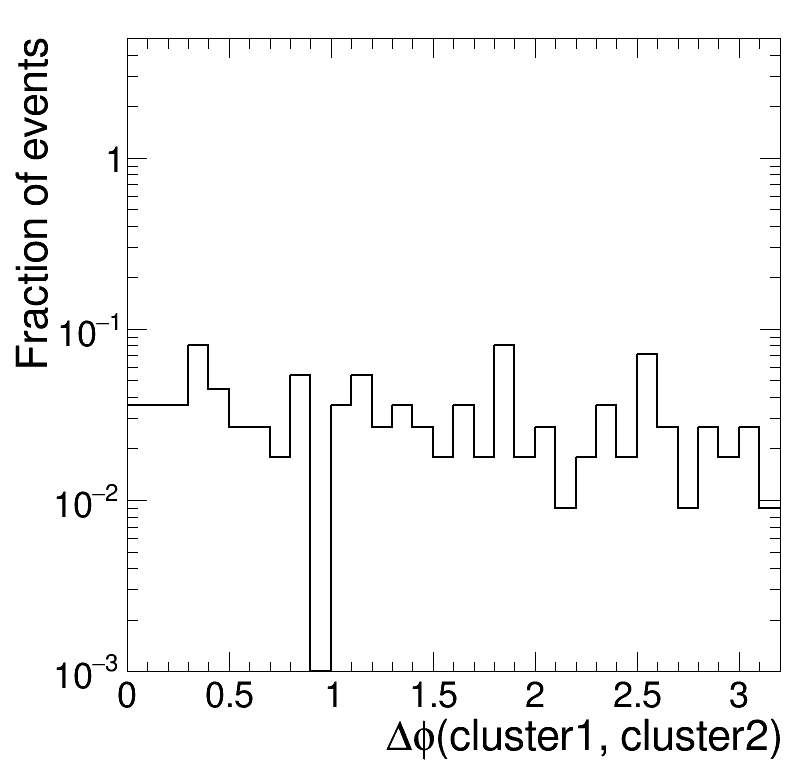

In [59]:
assert(category==2)



var = [dtRechitCluster_match_RPCBx_dPhi0p5, dtRechitClusterEta, dtRechitClusterAvgStation,cscRechitClusterTimeWeighted, cscRechitClusterEta, dtRechitClusterPhi]
name = ['dtRechitCluster_match_RPCBx_dPhi0p5', 'dtRechitClusterEta', 'dtRechitClusterAvgStation','cscRechitClusterTimeWeighted', 'cscRechitClusterEta', 'clusterDPhi']
xaxis = ['dt cluster BX', 'cluster #eta', 'cluster average station', 'cluster time [ns]', 'cluster #eta', '#Delta#phi(cluster1, cluster2)']


bins = [[10,-5,5], [20,0,1], [20,1,5],  [100,-100,120], [25,0.8,2.5], [32,0,3.2]]
# setlogy = [1,1,1,1,1,1,0,0,1,1,1,1]




for index in range(len(var)):
#     if not index == 3:continue
    c = rt.TCanvas('c','c', 800, 800)
    leg = rt.TLegend(0.6,0.7,0.8,0.92)
    leg.SetTextSize(0.03)
    leg.SetBorderSize(0)
    leg.SetEntrySeparation(0.01)
    h = {}

    for i, k in enumerate(weight.keys()):
#         if not k[-4:] == '1000' and not k == 'data':continue
        if k == 'data':cond =  np.logical_and(cscClusterSize[k]<100, dtRechitClusterSize[k]<80)
        else: cond =  cscClusterSize[k]>=50
        if not index == 3: 
            cond = np.logical_and(cond, np.logical_and(cscRechitClusterTimeWeighted[k]<12.5, cscRechitClusterTimeWeighted[k]>-5))

        if index == 0 or index == 3:h[k] = create_TH1D(var[index][k], axis_title = [xaxis[index], 'Fraction of events'], binning = bins[index])
        elif index == 5:h[k] = create_TH1D(np.abs(deltaPhi(dtRechitClusterPhi[k][cond], cscRechitClusterPhi[k][cond])), axis_title = [xaxis[index], 'Fraction of events'], binning = bins[index])
        else:h[k] = create_TH1D(np.abs(var[index][k]), axis_title = [xaxis[index], 'Fraction of events'], binning = bins[index])
    
        h[k].SetLineColor(std_color_list[i])
        if h[k].Integral()>0:h[k].Scale(1./h[k].Integral())

        h[k].SetMaximum(5)

        h[k].SetMaximum(5)
        h[k].SetMinimum(1e-3)
          
          
            
        h[k].Draw('hist same')

        


    # if setlog: 
    c.SetLogy()
    c.Draw()
    plot_path = '/storage/af/user/christiw/gpu/christiw/llp/delayed_jet_analyzer/plots/MuonSystem_Analysis/double_tag/selection_plots_final/'+v2+'/'
    if not os.path.exists(plot_path):os.makedirs(plot_path)
    c.SaveAs(plot_path+'dtcsc_'+name[index]+".png")
    c.SaveAs(plot_path+'dtcsc_'+name[index]+".pdf")
    c.SaveAs(plot_path+'dtcsc_'+name[index]+".C")


# DT Noise Hits

Warning in <TROOT::Append>: Replacing existing TH1: h (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h (Potential memory leak).


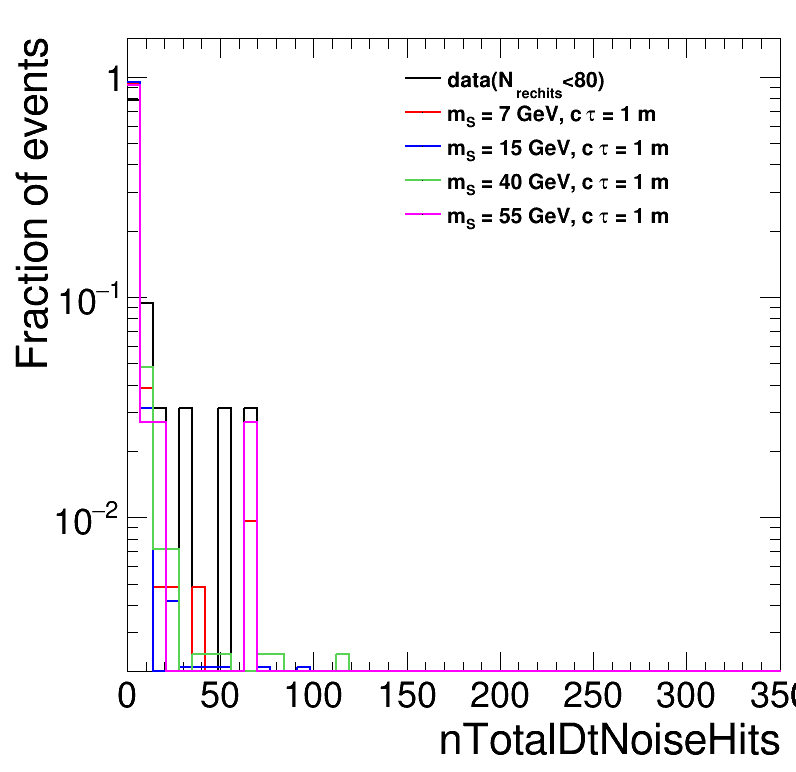

In [29]:
assert(category == 1)


var = [nTotalDtNoiseHits, nDTRechitsNoiseSec8, nDTRechitsNoiseSec9, nDTRechitsNoiseSec10]

name = ['nTotalDtNoiseHits', 'nDTRechitsNoiseSec8', 'nDTRechitsNoiseSec9', 'nDTRechitsNoiseSec10']
xaxis = ['nTotalDtNoiseHits', 'nDTRechitsNoiseSec8', 'nDTRechitsNoiseSec9', 'nDTRechitsNoiseSec10']

bins = [ [50,0,350]]*4


for index in range(len(var)):
    if not index == 0:continue
    c = rt.TCanvas('c','c', 800, 800)
    leg = rt.TLegend(0.5,0.7,0.75,0.92)
    leg.SetTextSize(0.03)
    leg.SetBorderSize(0)
    leg.SetEntrySeparation(0.01)
    h = {}

    for i, k in enumerate(weight.keys()):
        if not k[-4:] == '1000' and not k == 'data':continue
        if k == 'data':sel_dtcluster =  dtClusterSize[k]<80
        else: sel_dtcluster = dtClusterSize[k]>=80
        sel_dtcluster = np.logical_and(sel_dtcluster, dtRechitCluster_match_RPChits_dPhi0p5[k]>=1)
        sel_dtcluster = np.logical_and(sel_dtcluster, dtRechitClusterJetVetoPt[k]<50)
        sel_dtcluster = np.logical_and(sel_dtcluster, np.abs(dtRechitClusterDphi[k])<1.2)
        cond = sel_dtcluster.sum()==2

        h[k] = create_TH1D(np.abs(var[index][k][cond]), axis_title = [xaxis[index], 'Fraction of events'], binning = bins[index])
        #     print(k, np.count_nonzero(var[index][k][sel_csccluster][cond].max()<30)/np.count_nonzero(cond))
        if k == 'data':leg.AddEntry(h[k],k+'(N_{rechits}<80)')
        else: leg.AddEntry(h[k],'m_{S} = ' + k[k.find('m')+1:k.find('ctau')] + ' GeV, c#tau = 1 m')

#         if index == 0:print(k, np.count_nonzero(var[index][k][sel_dtcluster][cond].min()>=1)/np.count_nonzero(cond))
#         elif index == 1:print(k, np.count_nonzero(var[index][k][sel_dtcluster][cond].max()<50)/np.count_nonzero(cond))
#         elif index == 2:print(k, np.count_nonzero(np.abs(var[index][k][sel_dtcluster][cond]).max()<1)/np.count_nonzero(cond))
#         elif index == 3:print(k, np.count_nonzero(np.abs(var[index][k][sel_dtcluster][cond]).max()<0.9)/np.count_nonzero(cond))

        h[k].SetLineColor(std_color_list[i])
        if h[k].Integral()>0:h[k].Scale(1./h[k].Integral())

        if index == 4:h[k].SetMaximum(5)
        else: h[k].SetMaximum(1.5)
        h[k].SetMinimum(0.002)
        h[k].Draw('hist same')
    leg.Draw()
#     c.SetRightMargin(0.2)


    # if setlog: 
    c.SetLogy()
    c.Draw()
    plot_path = '/storage/af/user/christiw/gpu/christiw/llp/delayed_jet_analyzer/plots/MuonSystem_Analysis/double_tag/selection_plots'
#     c.SaveAs(plot_path+v2+'/'+name[index]+".png")
#     c.SaveAs(plot_path+v2+'/'+name[index]+".pdf")
#     c.SaveAs(plot_path+v2+'/'+name[index]+".C")



